In [1]:
from datetime import datetime
import os
import sys
sys.path.insert(0, '../../RISClusterPT/')

import h5py
from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError, Loss, RunningAverage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from RISCluster.processing import cluster
from RISCluster.processing.cluster import load_data, set_loading_index
from RISCluster.utils.utils import notify

In [2]:
fname_dataset = '../../../Data/DetectionData.h5'
savepath_fig, savepath_stats, savepath_model, savepath_data = cluster.init_output_env()

In [3]:
fname_dataset = '../../../Data/DetectionData.h5'
M = int(1000)
M_train = int(0.8 * M)
M_val = int(0.2 * M)
M_test = M
LR = 0.0001     # Learning rate
N_EPOCHS = 100  # Number of epochs
BATCH_SZ = 128  # Batch size

index_train, index_val, index_test = set_loading_index(M, fname_dataset, reserve=0.02)
X_train, m, p, n, o, idx_smpl_train = load_data(fname_dataset, M_train, index_train)
X_val, m, p, n, o, idx_smpl_val = load_data(fname_dataset, M_val, index_val)
# X_test, m, p, n, o, idx_smpl_test = load_data(fname_dataset, M_test, index_test)

--------------------------------------------------------------
H5 file has 5113 samples, 66 frequency bins, 301 time bins.
Loading 800 samples...
100.00% complete.
Time elapsed = 2020-07-15 12:57:26.027667
Shape of output is (800, 1, 64, 128)
--------------------------------------------------------------
--------------------------------------------------------------
H5 file has 5113 samples, 66 frequency bins, 301 time bins.
Loading 200 samples...
100.00% complete.
Time elapsed = 2020-07-15 12:57:26.127536
Shape of output is (200, 1, 64, 128)
--------------------------------------------------------------


In [4]:
train_loader = DataLoader(X_train, batch_size=BATCH_SZ)
val_loader = DataLoader(X_val, batch_size=BATCH_SZ)

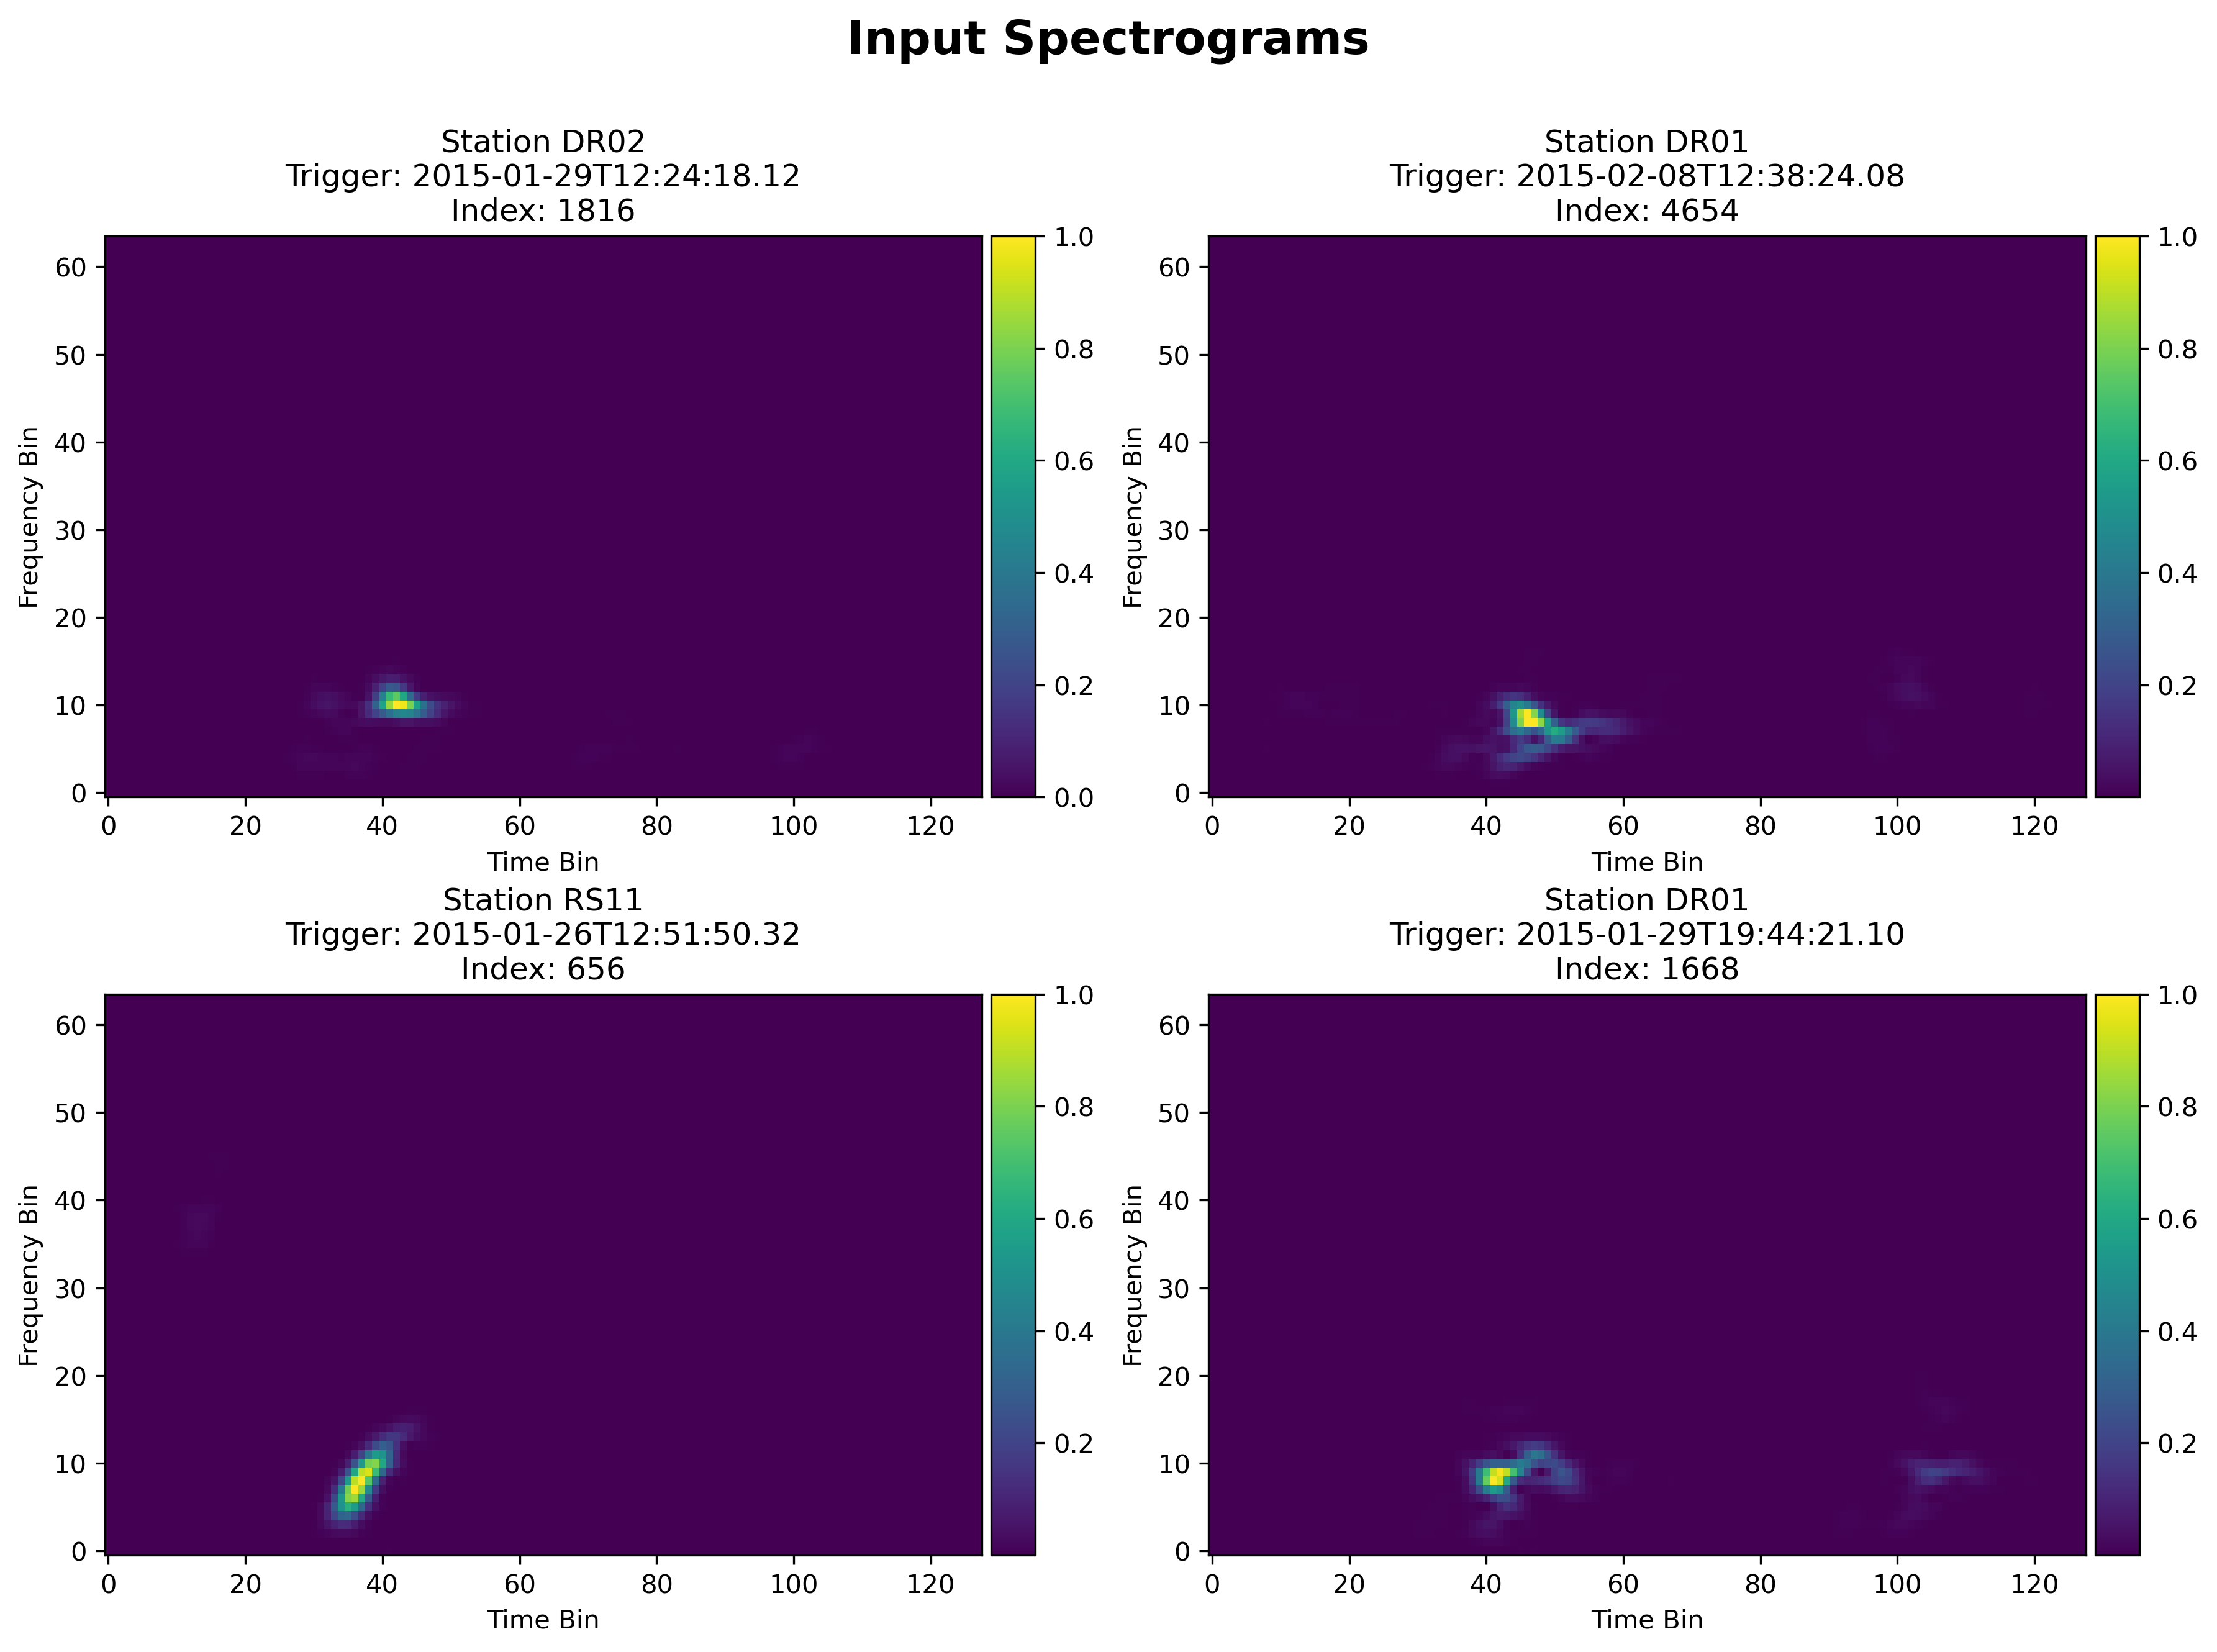

In [5]:
insp_idx = sorted(np.random.randint(0,len(X_train),4))

figtitle = 'Input Spectrograms'
fig = cluster.view_specgram(X_train, insp_idx, n, o, fname_dataset, idx_smpl_train,
                            figtitle, nrows=2, ncols=2, figsize=(12,9),
                            show=True)
fname = savepath_fig + '01_InputSpecGrams_' + \
        datetime.now().strftime('%Y%m%dT%H%M%S') + '.png'
fig.savefig(fname)

# writer = SummaryWriter('test_tensorboard')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available() is True:
    model = ConvAEC().to(device)
    print('CUDA device available, using GPU.')
else:
    model = cluster.ConvAEC()
    print('CUDA device not available, using CPU.')

optimizer = optim.Adam(model.parameters(), lr=LR)

mse_loss = nn.MSELoss()

CUDA device not available, using CPU.


In [7]:
def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch.to(device)
    x_pred = model(x)
    loss = mse_loss(x_pred, x)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_function(engine, batch):
    model.eval()
    with torch.no_grad():
        x = batch.to(device)
        x_pred = model(x)
        return x_pred, x

In [8]:
trainer = Engine(process_function)
evaluator = Engine(evaluate_function)
training_history = {'mse': []}
validation_history = {'mse': []}

In [9]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'mse')
MeanSquaredError(output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'mse')

In [10]:
@trainer.on(Events.EPOCH_COMPLETED)
def print_trainer_logs(engine):
    avg_loss = engine.state.metrics['mse']
    print("Trainer Results - Epoch {} - Avg mse: {:.2f}"
          .format(engine.state.epoch, avg_loss))

def print_logs(engine, dataloader, mode, history_dict):
    evaluator.run(dataloader, max_epochs=1)
    metrics = evaluator.state.metrics
    avg_mse = metrics['mse']
    print(
        mode + " Results - Epoch {} - Avg mse: {:.2f}"
        .format(engine.state.epoch, avg_mse))
    for key in evaluator.state.metrics.keys():
        history_dict[key].append(evaluator.state.metrics[key])

trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, train_loader, 'Training', training_history)
trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, val_loader, 'Validation', validation_history)

In [11]:
fixed_images = X_train[0:2,:,:,:].to(device)
fixed_images.shape

torch.Size([2, 1, 64, 128])

In [12]:
def compare_images(engine, save_img=False):
    epoch = engine.state.epoch
    fixed_image = X_train[0,:,:,:]
    reconstructed_images = model(fixed_images)
    comparison = torch.cat([fixed_images, reconstructed_images])
    if save_img:
        save_image(comparison.detach().cpu(), 'reconstructed_epoch_' + str(epoch) + '.png', nrow=8)
    comparison_images = make_grid(comparison.detach().cpu(), nrow=2)
    fig = plt.figure(figsize=(10, 10))
    output = plt.imshow(comparison_images.permute(1, 2, 0))
    plt.gca().invert_yaxis()
    plt.title('Epoch ' + str(epoch))
    plt.show()

trainer.add_event_handler(Events.STARTED, compare_images, save_img=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), compare_images, save_img=False)

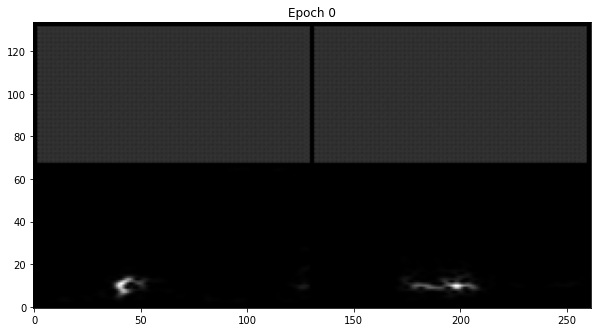

Trainer Results - Epoch 1 - Avg mse: 0.03
Training Results - Epoch 1 - Avg mse: 276.46
Validation Results - Epoch 1 - Avg mse: 276.15
Trainer Results - Epoch 2 - Avg mse: 0.03
Training Results - Epoch 2 - Avg mse: 268.08
Validation Results - Epoch 2 - Avg mse: 267.78
Trainer Results - Epoch 3 - Avg mse: 0.03
Training Results - Epoch 3 - Avg mse: 259.19
Validation Results - Epoch 3 - Avg mse: 258.90
Trainer Results - Epoch 4 - Avg mse: 0.03
Training Results - Epoch 4 - Avg mse: 249.24
Validation Results - Epoch 4 - Avg mse: 248.96
Trainer Results - Epoch 5 - Avg mse: 0.03
Training Results - Epoch 5 - Avg mse: 237.09
Validation Results - Epoch 5 - Avg mse: 236.81


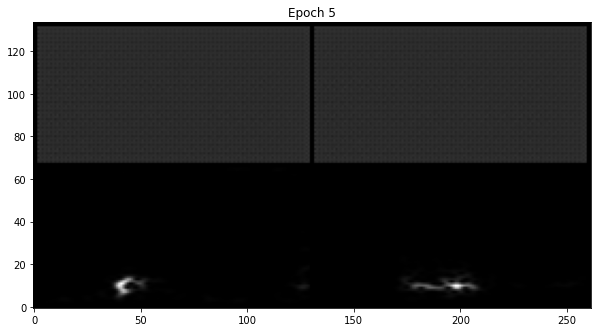

Trainer Results - Epoch 6 - Avg mse: 0.03
Training Results - Epoch 6 - Avg mse: 220.37
Validation Results - Epoch 6 - Avg mse: 220.11
Trainer Results - Epoch 7 - Avg mse: 0.03
Training Results - Epoch 7 - Avg mse: 195.01
Validation Results - Epoch 7 - Avg mse: 194.77
Trainer Results - Epoch 8 - Avg mse: 0.02
Training Results - Epoch 8 - Avg mse: 147.96
Validation Results - Epoch 8 - Avg mse: 147.79
Trainer Results - Epoch 9 - Avg mse: 0.02
Training Results - Epoch 9 - Avg mse: 87.36
Validation Results - Epoch 9 - Avg mse: 87.35
Trainer Results - Epoch 10 - Avg mse: 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 10 - Avg mse: 78.18
Validation Results - Epoch 10 - Avg mse: 78.38


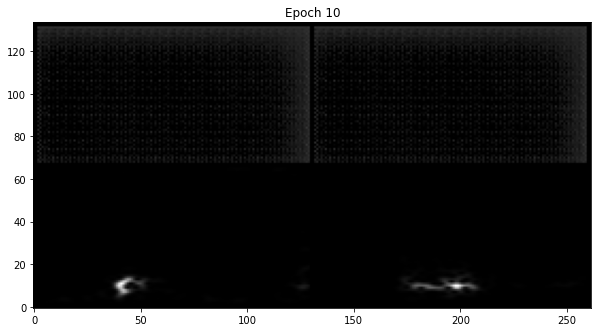

Trainer Results - Epoch 11 - Avg mse: 0.01
Training Results - Epoch 11 - Avg mse: 57.27
Validation Results - Epoch 11 - Avg mse: 57.35
Trainer Results - Epoch 12 - Avg mse: 0.01
Training Results - Epoch 12 - Avg mse: 51.03
Validation Results - Epoch 12 - Avg mse: 51.07
Trainer Results - Epoch 13 - Avg mse: 0.01
Training Results - Epoch 13 - Avg mse: 43.44
Validation Results - Epoch 13 - Avg mse: 43.53
Trainer Results - Epoch 14 - Avg mse: 0.01
Training Results - Epoch 14 - Avg mse: 39.96
Validation Results - Epoch 14 - Avg mse: 40.07
Trainer Results - Epoch 15 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 15 - Avg mse: 36.59
Validation Results - Epoch 15 - Avg mse: 36.67


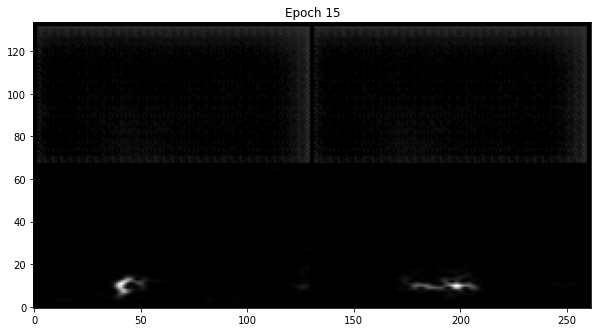

Trainer Results - Epoch 16 - Avg mse: 0.00
Training Results - Epoch 16 - Avg mse: 34.23
Validation Results - Epoch 16 - Avg mse: 34.30
Trainer Results - Epoch 17 - Avg mse: 0.00
Training Results - Epoch 17 - Avg mse: 32.15
Validation Results - Epoch 17 - Avg mse: 32.24
Trainer Results - Epoch 18 - Avg mse: 0.00
Training Results - Epoch 18 - Avg mse: 30.40
Validation Results - Epoch 18 - Avg mse: 30.47
Trainer Results - Epoch 19 - Avg mse: 0.00
Training Results - Epoch 19 - Avg mse: 28.91
Validation Results - Epoch 19 - Avg mse: 28.98
Trainer Results - Epoch 20 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 20 - Avg mse: 27.61
Validation Results - Epoch 20 - Avg mse: 27.67


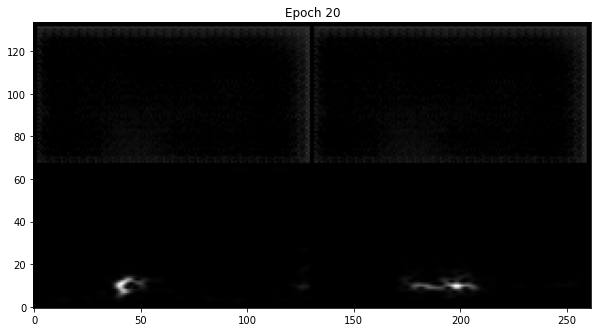

Trainer Results - Epoch 21 - Avg mse: 0.00
Training Results - Epoch 21 - Avg mse: 26.47
Validation Results - Epoch 21 - Avg mse: 26.54
Trainer Results - Epoch 22 - Avg mse: 0.00
Training Results - Epoch 22 - Avg mse: 25.47
Validation Results - Epoch 22 - Avg mse: 25.54
Trainer Results - Epoch 23 - Avg mse: 0.00
Training Results - Epoch 23 - Avg mse: 24.59
Validation Results - Epoch 23 - Avg mse: 24.66
Trainer Results - Epoch 24 - Avg mse: 0.00
Training Results - Epoch 24 - Avg mse: 23.81
Validation Results - Epoch 24 - Avg mse: 23.88
Trainer Results - Epoch 25 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 25 - Avg mse: 23.11
Validation Results - Epoch 25 - Avg mse: 23.18


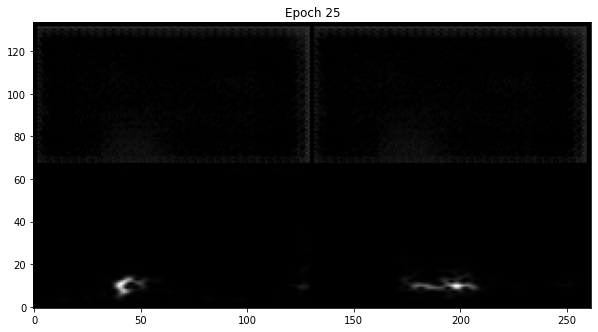

Trainer Results - Epoch 26 - Avg mse: 0.00
Training Results - Epoch 26 - Avg mse: 22.48
Validation Results - Epoch 26 - Avg mse: 22.55
Trainer Results - Epoch 27 - Avg mse: 0.00
Training Results - Epoch 27 - Avg mse: 21.92
Validation Results - Epoch 27 - Avg mse: 21.99
Trainer Results - Epoch 28 - Avg mse: 0.00
Training Results - Epoch 28 - Avg mse: 21.41
Validation Results - Epoch 28 - Avg mse: 21.48
Trainer Results - Epoch 29 - Avg mse: 0.00
Training Results - Epoch 29 - Avg mse: 20.93
Validation Results - Epoch 29 - Avg mse: 21.00
Trainer Results - Epoch 30 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 30 - Avg mse: 20.48
Validation Results - Epoch 30 - Avg mse: 20.56


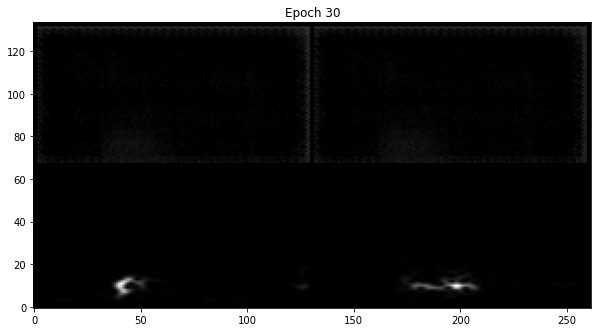

Trainer Results - Epoch 31 - Avg mse: 0.00
Training Results - Epoch 31 - Avg mse: 20.07
Validation Results - Epoch 31 - Avg mse: 20.14
Trainer Results - Epoch 32 - Avg mse: 0.00
Training Results - Epoch 32 - Avg mse: 19.68
Validation Results - Epoch 32 - Avg mse: 19.76
Trainer Results - Epoch 33 - Avg mse: 0.00
Training Results - Epoch 33 - Avg mse: 19.32
Validation Results - Epoch 33 - Avg mse: 19.40
Trainer Results - Epoch 34 - Avg mse: 0.00
Training Results - Epoch 34 - Avg mse: 18.98
Validation Results - Epoch 34 - Avg mse: 19.06
Trainer Results - Epoch 35 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 35 - Avg mse: 18.67
Validation Results - Epoch 35 - Avg mse: 18.74


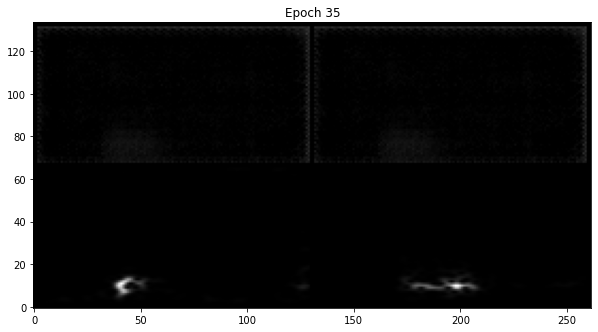

Trainer Results - Epoch 36 - Avg mse: 0.00
Training Results - Epoch 36 - Avg mse: 18.36
Validation Results - Epoch 36 - Avg mse: 18.44
Trainer Results - Epoch 37 - Avg mse: 0.00
Training Results - Epoch 37 - Avg mse: 18.08
Validation Results - Epoch 37 - Avg mse: 18.15
Trainer Results - Epoch 38 - Avg mse: 0.00
Training Results - Epoch 38 - Avg mse: 17.81
Validation Results - Epoch 38 - Avg mse: 17.88
Trainer Results - Epoch 39 - Avg mse: 0.00
Training Results - Epoch 39 - Avg mse: 17.56
Validation Results - Epoch 39 - Avg mse: 17.64
Trainer Results - Epoch 40 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 40 - Avg mse: 17.33
Validation Results - Epoch 40 - Avg mse: 17.40


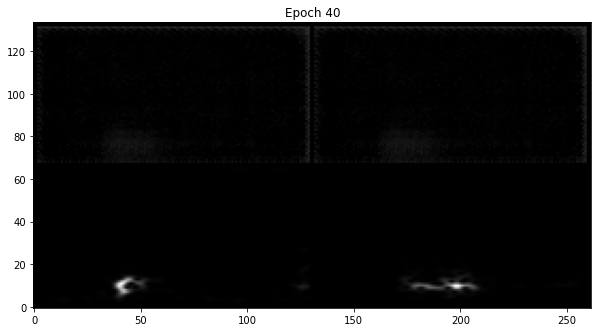

Trainer Results - Epoch 41 - Avg mse: 0.00
Training Results - Epoch 41 - Avg mse: 17.11
Validation Results - Epoch 41 - Avg mse: 17.18
Trainer Results - Epoch 42 - Avg mse: 0.00
Training Results - Epoch 42 - Avg mse: 16.90
Validation Results - Epoch 42 - Avg mse: 16.97
Trainer Results - Epoch 43 - Avg mse: 0.00
Training Results - Epoch 43 - Avg mse: 16.70
Validation Results - Epoch 43 - Avg mse: 16.77
Trainer Results - Epoch 44 - Avg mse: 0.00
Training Results - Epoch 44 - Avg mse: 16.52
Validation Results - Epoch 44 - Avg mse: 16.58
Trainer Results - Epoch 45 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 45 - Avg mse: 16.34
Validation Results - Epoch 45 - Avg mse: 16.41


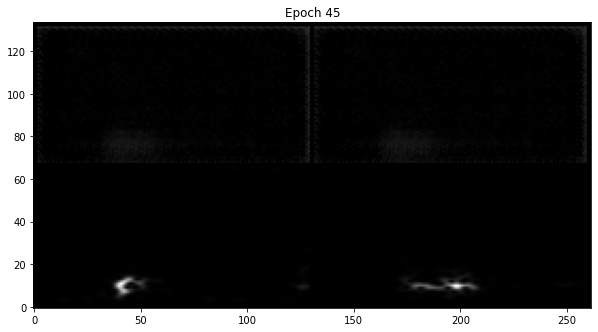

Trainer Results - Epoch 46 - Avg mse: 0.00
Training Results - Epoch 46 - Avg mse: 16.18
Validation Results - Epoch 46 - Avg mse: 16.24
Trainer Results - Epoch 47 - Avg mse: 0.00
Training Results - Epoch 47 - Avg mse: 16.02
Validation Results - Epoch 47 - Avg mse: 16.07
Trainer Results - Epoch 48 - Avg mse: 0.00
Training Results - Epoch 48 - Avg mse: 15.86
Validation Results - Epoch 48 - Avg mse: 15.92
Trainer Results - Epoch 49 - Avg mse: 0.00
Training Results - Epoch 49 - Avg mse: 15.71
Validation Results - Epoch 49 - Avg mse: 15.77
Trainer Results - Epoch 50 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 50 - Avg mse: 15.57
Validation Results - Epoch 50 - Avg mse: 15.62


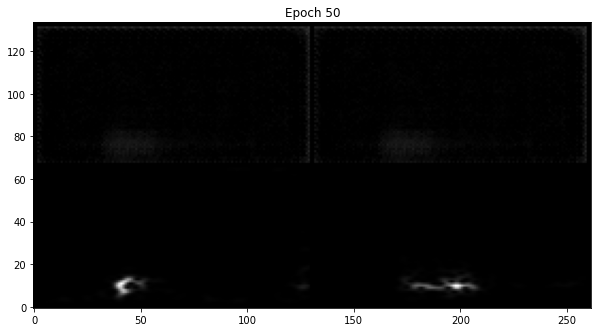

Trainer Results - Epoch 51 - Avg mse: 0.00
Training Results - Epoch 51 - Avg mse: 15.43
Validation Results - Epoch 51 - Avg mse: 15.48
Trainer Results - Epoch 52 - Avg mse: 0.00
Training Results - Epoch 52 - Avg mse: 15.29
Validation Results - Epoch 52 - Avg mse: 15.34
Trainer Results - Epoch 53 - Avg mse: 0.00
Training Results - Epoch 53 - Avg mse: 15.16
Validation Results - Epoch 53 - Avg mse: 15.21
Trainer Results - Epoch 54 - Avg mse: 0.00
Training Results - Epoch 54 - Avg mse: 15.03
Validation Results - Epoch 54 - Avg mse: 15.08
Trainer Results - Epoch 55 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 55 - Avg mse: 14.91
Validation Results - Epoch 55 - Avg mse: 14.95


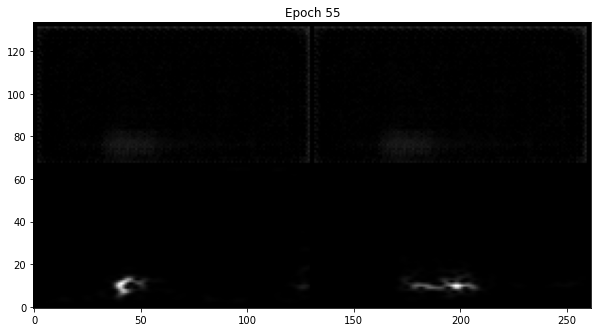

Trainer Results - Epoch 56 - Avg mse: 0.00
Training Results - Epoch 56 - Avg mse: 14.78
Validation Results - Epoch 56 - Avg mse: 14.83
Trainer Results - Epoch 57 - Avg mse: 0.00
Training Results - Epoch 57 - Avg mse: 14.66
Validation Results - Epoch 57 - Avg mse: 14.71
Trainer Results - Epoch 58 - Avg mse: 0.00
Training Results - Epoch 58 - Avg mse: 14.54
Validation Results - Epoch 58 - Avg mse: 14.58
Trainer Results - Epoch 59 - Avg mse: 0.00
Training Results - Epoch 59 - Avg mse: 14.42
Validation Results - Epoch 59 - Avg mse: 14.47
Trainer Results - Epoch 60 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 60 - Avg mse: 14.31
Validation Results - Epoch 60 - Avg mse: 14.35


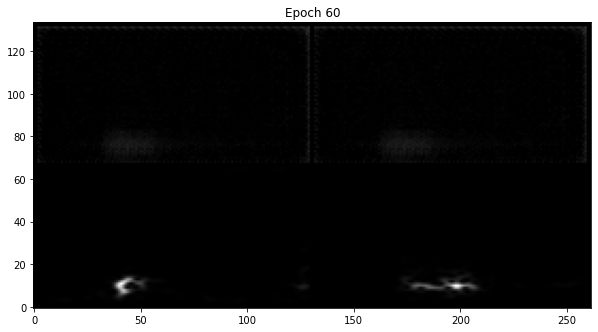

Trainer Results - Epoch 61 - Avg mse: 0.00
Training Results - Epoch 61 - Avg mse: 14.20
Validation Results - Epoch 61 - Avg mse: 14.24
Trainer Results - Epoch 62 - Avg mse: 0.00
Training Results - Epoch 62 - Avg mse: 14.09
Validation Results - Epoch 62 - Avg mse: 14.14
Trainer Results - Epoch 63 - Avg mse: 0.00
Training Results - Epoch 63 - Avg mse: 13.99
Validation Results - Epoch 63 - Avg mse: 14.03
Trainer Results - Epoch 64 - Avg mse: 0.00
Training Results - Epoch 64 - Avg mse: 13.89
Validation Results - Epoch 64 - Avg mse: 13.93
Trainer Results - Epoch 65 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 65 - Avg mse: 13.79
Validation Results - Epoch 65 - Avg mse: 13.83


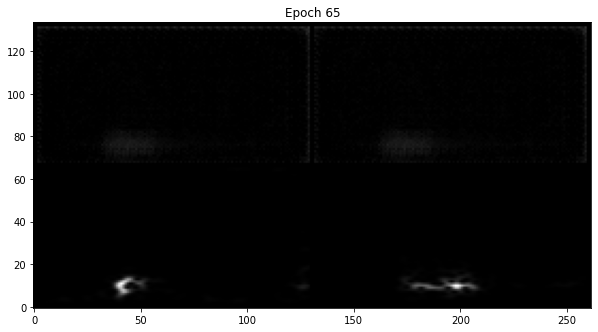

Trainer Results - Epoch 66 - Avg mse: 0.00
Training Results - Epoch 66 - Avg mse: 13.69
Validation Results - Epoch 66 - Avg mse: 13.73
Trainer Results - Epoch 67 - Avg mse: 0.00
Training Results - Epoch 67 - Avg mse: 13.59
Validation Results - Epoch 67 - Avg mse: 13.63
Trainer Results - Epoch 68 - Avg mse: 0.00
Training Results - Epoch 68 - Avg mse: 13.50
Validation Results - Epoch 68 - Avg mse: 13.54
Trainer Results - Epoch 69 - Avg mse: 0.00
Training Results - Epoch 69 - Avg mse: 13.41
Validation Results - Epoch 69 - Avg mse: 13.45
Trainer Results - Epoch 70 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 70 - Avg mse: 13.32
Validation Results - Epoch 70 - Avg mse: 13.36


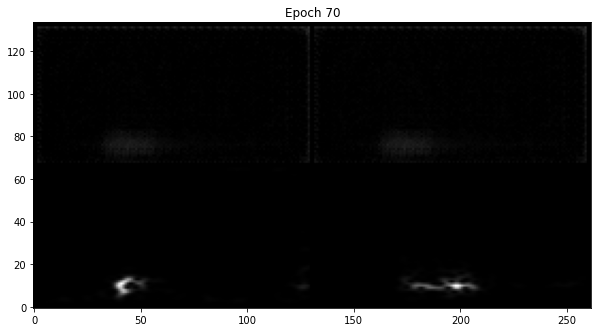

Trainer Results - Epoch 71 - Avg mse: 0.00
Training Results - Epoch 71 - Avg mse: 13.24
Validation Results - Epoch 71 - Avg mse: 13.28
Trainer Results - Epoch 72 - Avg mse: 0.00
Training Results - Epoch 72 - Avg mse: 13.15
Validation Results - Epoch 72 - Avg mse: 13.19
Trainer Results - Epoch 73 - Avg mse: 0.00
Training Results - Epoch 73 - Avg mse: 13.07
Validation Results - Epoch 73 - Avg mse: 13.11
Trainer Results - Epoch 74 - Avg mse: 0.00
Training Results - Epoch 74 - Avg mse: 12.99
Validation Results - Epoch 74 - Avg mse: 13.03
Trainer Results - Epoch 75 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 75 - Avg mse: 12.91
Validation Results - Epoch 75 - Avg mse: 12.95


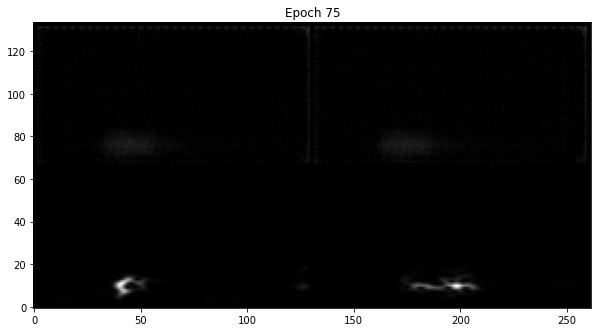

Trainer Results - Epoch 76 - Avg mse: 0.00
Training Results - Epoch 76 - Avg mse: 12.84
Validation Results - Epoch 76 - Avg mse: 12.88
Trainer Results - Epoch 77 - Avg mse: 0.00
Training Results - Epoch 77 - Avg mse: 12.77
Validation Results - Epoch 77 - Avg mse: 12.80
Trainer Results - Epoch 78 - Avg mse: 0.00
Training Results - Epoch 78 - Avg mse: 12.69
Validation Results - Epoch 78 - Avg mse: 12.73
Trainer Results - Epoch 79 - Avg mse: 0.00
Training Results - Epoch 79 - Avg mse: 12.63
Validation Results - Epoch 79 - Avg mse: 12.66
Trainer Results - Epoch 80 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 80 - Avg mse: 12.56
Validation Results - Epoch 80 - Avg mse: 12.60


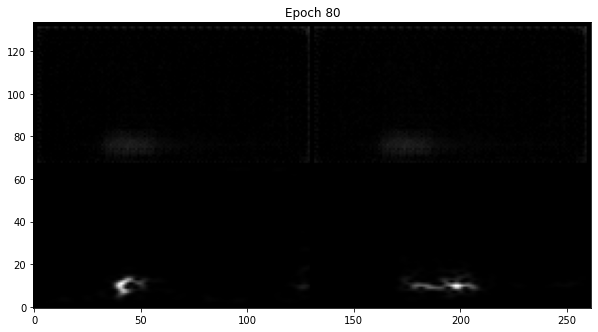

Trainer Results - Epoch 81 - Avg mse: 0.00
Training Results - Epoch 81 - Avg mse: 12.49
Validation Results - Epoch 81 - Avg mse: 12.53
Trainer Results - Epoch 82 - Avg mse: 0.00
Training Results - Epoch 82 - Avg mse: 12.43
Validation Results - Epoch 82 - Avg mse: 12.47
Trainer Results - Epoch 83 - Avg mse: 0.00
Training Results - Epoch 83 - Avg mse: 12.37
Validation Results - Epoch 83 - Avg mse: 12.40
Trainer Results - Epoch 84 - Avg mse: 0.00
Training Results - Epoch 84 - Avg mse: 12.31
Validation Results - Epoch 84 - Avg mse: 12.34
Trainer Results - Epoch 85 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 85 - Avg mse: 12.25
Validation Results - Epoch 85 - Avg mse: 12.29


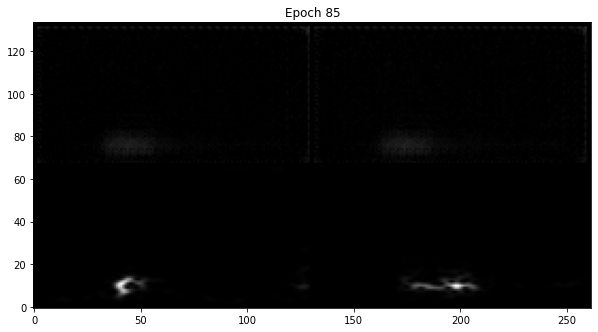

Trainer Results - Epoch 86 - Avg mse: 0.00
Training Results - Epoch 86 - Avg mse: 12.19
Validation Results - Epoch 86 - Avg mse: 12.23
Trainer Results - Epoch 87 - Avg mse: 0.00
Training Results - Epoch 87 - Avg mse: 12.14
Validation Results - Epoch 87 - Avg mse: 12.17
Trainer Results - Epoch 88 - Avg mse: 0.00
Training Results - Epoch 88 - Avg mse: 12.08
Validation Results - Epoch 88 - Avg mse: 12.12
Trainer Results - Epoch 89 - Avg mse: 0.00
Training Results - Epoch 89 - Avg mse: 12.03
Validation Results - Epoch 89 - Avg mse: 12.07
Trainer Results - Epoch 90 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 90 - Avg mse: 11.98
Validation Results - Epoch 90 - Avg mse: 12.02


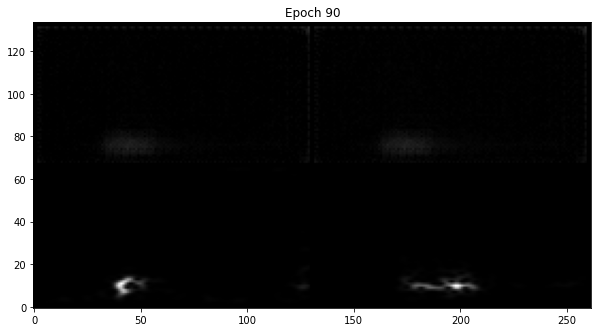

Trainer Results - Epoch 91 - Avg mse: 0.00
Training Results - Epoch 91 - Avg mse: 11.93
Validation Results - Epoch 91 - Avg mse: 11.97
Trainer Results - Epoch 92 - Avg mse: 0.00
Training Results - Epoch 92 - Avg mse: 11.88
Validation Results - Epoch 92 - Avg mse: 11.92
Trainer Results - Epoch 93 - Avg mse: 0.00
Training Results - Epoch 93 - Avg mse: 11.84
Validation Results - Epoch 93 - Avg mse: 11.87
Trainer Results - Epoch 94 - Avg mse: 0.00
Training Results - Epoch 94 - Avg mse: 11.79
Validation Results - Epoch 94 - Avg mse: 11.83
Trainer Results - Epoch 95 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 95 - Avg mse: 11.75
Validation Results - Epoch 95 - Avg mse: 11.78


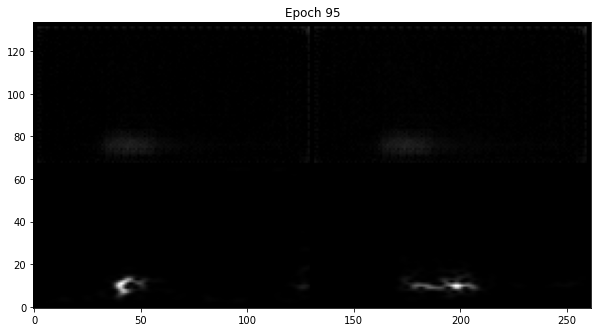

Trainer Results - Epoch 96 - Avg mse: 0.00
Training Results - Epoch 96 - Avg mse: 11.70
Validation Results - Epoch 96 - Avg mse: 11.74
Trainer Results - Epoch 97 - Avg mse: 0.00
Training Results - Epoch 97 - Avg mse: 11.66
Validation Results - Epoch 97 - Avg mse: 11.70
Trainer Results - Epoch 98 - Avg mse: 0.00
Training Results - Epoch 98 - Avg mse: 11.62
Validation Results - Epoch 98 - Avg mse: 11.65
Trainer Results - Epoch 99 - Avg mse: 0.00
Training Results - Epoch 99 - Avg mse: 11.57
Validation Results - Epoch 99 - Avg mse: 11.60
Trainer Results - Epoch 100 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 100 - Avg mse: 11.52
Validation Results - Epoch 100 - Avg mse: 11.55


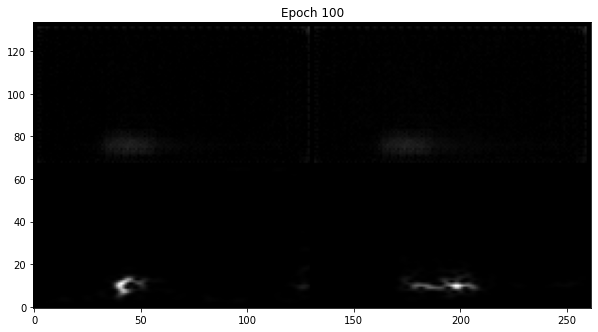

Trainer Results - Epoch 101 - Avg mse: 0.00
Training Results - Epoch 101 - Avg mse: 11.47
Validation Results - Epoch 101 - Avg mse: 11.51
Trainer Results - Epoch 102 - Avg mse: 0.00
Training Results - Epoch 102 - Avg mse: 11.42
Validation Results - Epoch 102 - Avg mse: 11.45
Trainer Results - Epoch 103 - Avg mse: 0.00
Training Results - Epoch 103 - Avg mse: 11.36
Validation Results - Epoch 103 - Avg mse: 11.39
Trainer Results - Epoch 104 - Avg mse: 0.00
Training Results - Epoch 104 - Avg mse: 11.30
Validation Results - Epoch 104 - Avg mse: 11.34
Trainer Results - Epoch 105 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 105 - Avg mse: 11.24
Validation Results - Epoch 105 - Avg mse: 11.27


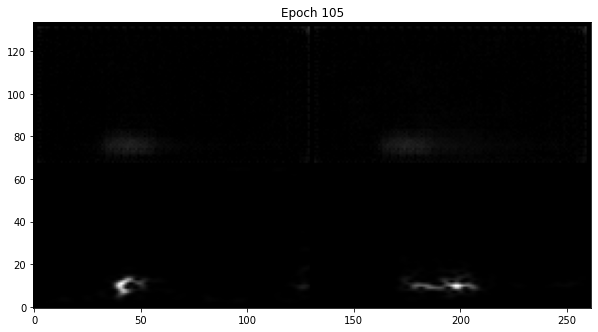

Trainer Results - Epoch 106 - Avg mse: 0.00
Training Results - Epoch 106 - Avg mse: 11.18
Validation Results - Epoch 106 - Avg mse: 11.21
Trainer Results - Epoch 107 - Avg mse: 0.00
Training Results - Epoch 107 - Avg mse: 11.12
Validation Results - Epoch 107 - Avg mse: 11.16
Trainer Results - Epoch 108 - Avg mse: 0.00
Training Results - Epoch 108 - Avg mse: 11.07
Validation Results - Epoch 108 - Avg mse: 11.11
Trainer Results - Epoch 109 - Avg mse: 0.00
Training Results - Epoch 109 - Avg mse: 11.02
Validation Results - Epoch 109 - Avg mse: 11.06
Trainer Results - Epoch 110 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 110 - Avg mse: 10.97
Validation Results - Epoch 110 - Avg mse: 11.01


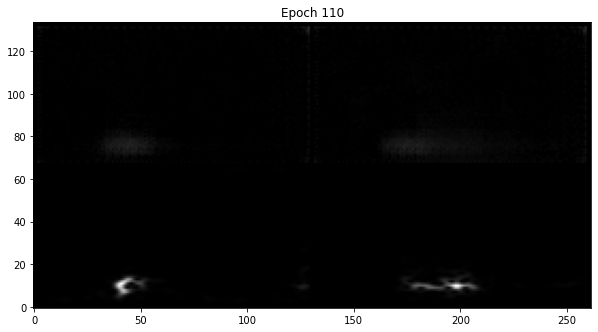

Trainer Results - Epoch 111 - Avg mse: 0.00
Training Results - Epoch 111 - Avg mse: 10.92
Validation Results - Epoch 111 - Avg mse: 10.96
Trainer Results - Epoch 112 - Avg mse: 0.00
Training Results - Epoch 112 - Avg mse: 10.88
Validation Results - Epoch 112 - Avg mse: 10.92
Trainer Results - Epoch 113 - Avg mse: 0.00
Training Results - Epoch 113 - Avg mse: 10.83
Validation Results - Epoch 113 - Avg mse: 10.87
Trainer Results - Epoch 114 - Avg mse: 0.00
Training Results - Epoch 114 - Avg mse: 10.78
Validation Results - Epoch 114 - Avg mse: 10.83
Trainer Results - Epoch 115 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 115 - Avg mse: 10.73
Validation Results - Epoch 115 - Avg mse: 10.78


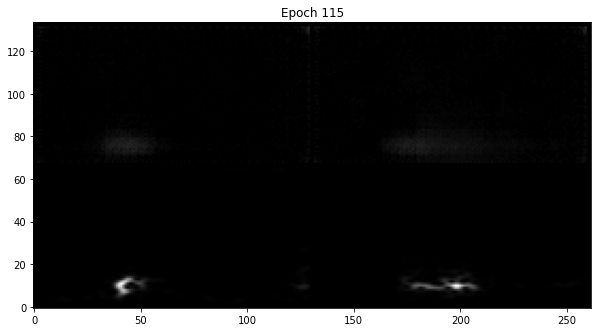

Trainer Results - Epoch 116 - Avg mse: 0.00
Training Results - Epoch 116 - Avg mse: 10.68
Validation Results - Epoch 116 - Avg mse: 10.73
Trainer Results - Epoch 117 - Avg mse: 0.00
Training Results - Epoch 117 - Avg mse: 10.63
Validation Results - Epoch 117 - Avg mse: 10.68
Trainer Results - Epoch 118 - Avg mse: 0.00
Training Results - Epoch 118 - Avg mse: 10.58
Validation Results - Epoch 118 - Avg mse: 10.64
Trainer Results - Epoch 119 - Avg mse: 0.00
Training Results - Epoch 119 - Avg mse: 10.53
Validation Results - Epoch 119 - Avg mse: 10.59
Trainer Results - Epoch 120 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 120 - Avg mse: 10.48
Validation Results - Epoch 120 - Avg mse: 10.54


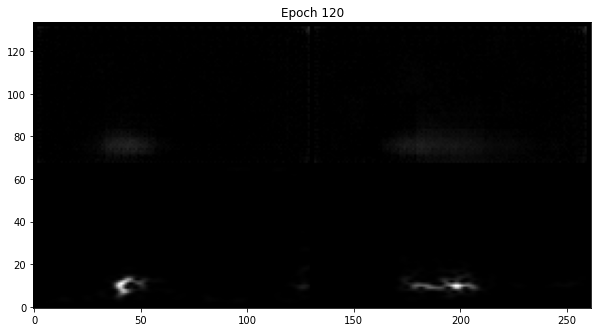

Trainer Results - Epoch 121 - Avg mse: 0.00
Training Results - Epoch 121 - Avg mse: 10.43
Validation Results - Epoch 121 - Avg mse: 10.49
Trainer Results - Epoch 122 - Avg mse: 0.00
Training Results - Epoch 122 - Avg mse: 10.38
Validation Results - Epoch 122 - Avg mse: 10.44
Trainer Results - Epoch 123 - Avg mse: 0.00
Training Results - Epoch 123 - Avg mse: 10.33
Validation Results - Epoch 123 - Avg mse: 10.39
Trainer Results - Epoch 124 - Avg mse: 0.00
Training Results - Epoch 124 - Avg mse: 10.28
Validation Results - Epoch 124 - Avg mse: 10.34
Trainer Results - Epoch 125 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 125 - Avg mse: 10.23
Validation Results - Epoch 125 - Avg mse: 10.30


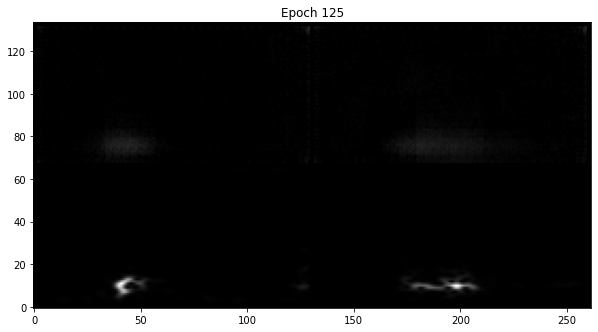

Trainer Results - Epoch 126 - Avg mse: 0.00
Training Results - Epoch 126 - Avg mse: 10.18
Validation Results - Epoch 126 - Avg mse: 10.25
Trainer Results - Epoch 127 - Avg mse: 0.00
Training Results - Epoch 127 - Avg mse: 10.14
Validation Results - Epoch 127 - Avg mse: 10.21
Trainer Results - Epoch 128 - Avg mse: 0.00
Training Results - Epoch 128 - Avg mse: 10.09
Validation Results - Epoch 128 - Avg mse: 10.16
Trainer Results - Epoch 129 - Avg mse: 0.00
Training Results - Epoch 129 - Avg mse: 10.05
Validation Results - Epoch 129 - Avg mse: 10.12
Trainer Results - Epoch 130 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 130 - Avg mse: 10.00
Validation Results - Epoch 130 - Avg mse: 10.08


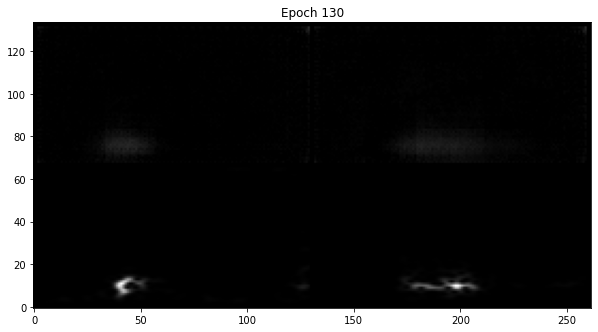

Trainer Results - Epoch 131 - Avg mse: 0.00
Training Results - Epoch 131 - Avg mse: 9.96
Validation Results - Epoch 131 - Avg mse: 10.04
Trainer Results - Epoch 132 - Avg mse: 0.00
Training Results - Epoch 132 - Avg mse: 9.92
Validation Results - Epoch 132 - Avg mse: 10.01
Trainer Results - Epoch 133 - Avg mse: 0.00
Training Results - Epoch 133 - Avg mse: 9.89
Validation Results - Epoch 133 - Avg mse: 9.97
Trainer Results - Epoch 134 - Avg mse: 0.00
Training Results - Epoch 134 - Avg mse: 9.85
Validation Results - Epoch 134 - Avg mse: 9.93
Trainer Results - Epoch 135 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 135 - Avg mse: 9.81
Validation Results - Epoch 135 - Avg mse: 9.90


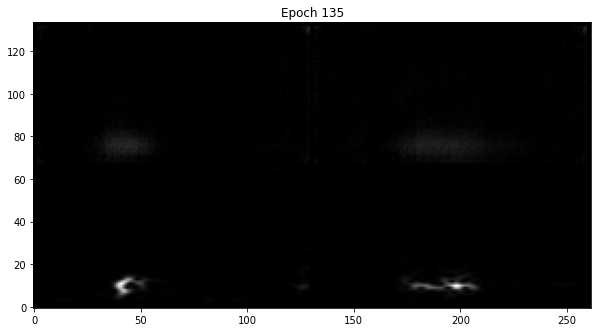

Trainer Results - Epoch 136 - Avg mse: 0.00
Training Results - Epoch 136 - Avg mse: 9.78
Validation Results - Epoch 136 - Avg mse: 9.87
Trainer Results - Epoch 137 - Avg mse: 0.00
Training Results - Epoch 137 - Avg mse: 9.75
Validation Results - Epoch 137 - Avg mse: 9.84
Trainer Results - Epoch 138 - Avg mse: 0.00
Training Results - Epoch 138 - Avg mse: 9.71
Validation Results - Epoch 138 - Avg mse: 9.80
Trainer Results - Epoch 139 - Avg mse: 0.00
Training Results - Epoch 139 - Avg mse: 9.68
Validation Results - Epoch 139 - Avg mse: 9.77
Trainer Results - Epoch 140 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 140 - Avg mse: 9.65
Validation Results - Epoch 140 - Avg mse: 9.74


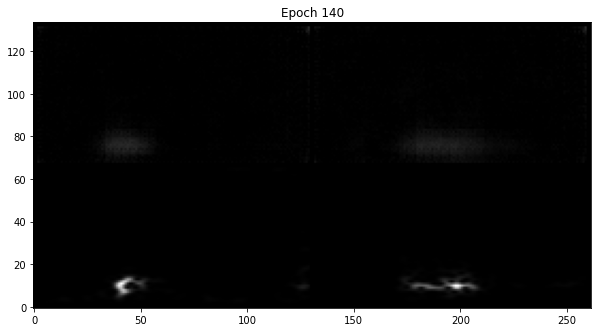

Trainer Results - Epoch 141 - Avg mse: 0.00
Training Results - Epoch 141 - Avg mse: 9.62
Validation Results - Epoch 141 - Avg mse: 9.72
Trainer Results - Epoch 142 - Avg mse: 0.00
Training Results - Epoch 142 - Avg mse: 9.59
Validation Results - Epoch 142 - Avg mse: 9.69
Trainer Results - Epoch 143 - Avg mse: 0.00
Training Results - Epoch 143 - Avg mse: 9.56
Validation Results - Epoch 143 - Avg mse: 9.66
Trainer Results - Epoch 144 - Avg mse: 0.00
Training Results - Epoch 144 - Avg mse: 9.54
Validation Results - Epoch 144 - Avg mse: 9.63
Trainer Results - Epoch 145 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 145 - Avg mse: 9.51
Validation Results - Epoch 145 - Avg mse: 9.61


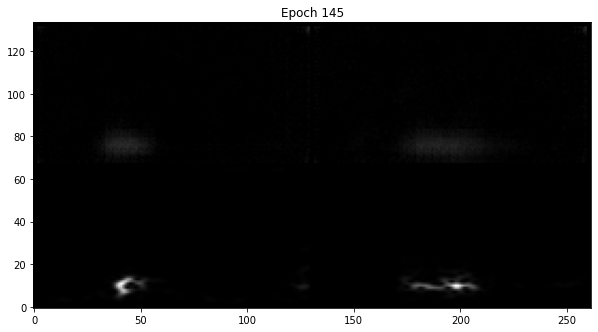

Trainer Results - Epoch 146 - Avg mse: 0.00
Training Results - Epoch 146 - Avg mse: 9.48
Validation Results - Epoch 146 - Avg mse: 9.58
Trainer Results - Epoch 147 - Avg mse: 0.00
Training Results - Epoch 147 - Avg mse: 9.45
Validation Results - Epoch 147 - Avg mse: 9.56
Trainer Results - Epoch 148 - Avg mse: 0.00
Training Results - Epoch 148 - Avg mse: 9.43
Validation Results - Epoch 148 - Avg mse: 9.53
Trainer Results - Epoch 149 - Avg mse: 0.00
Training Results - Epoch 149 - Avg mse: 9.40
Validation Results - Epoch 149 - Avg mse: 9.51
Trainer Results - Epoch 150 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 150 - Avg mse: 9.38
Validation Results - Epoch 150 - Avg mse: 9.48


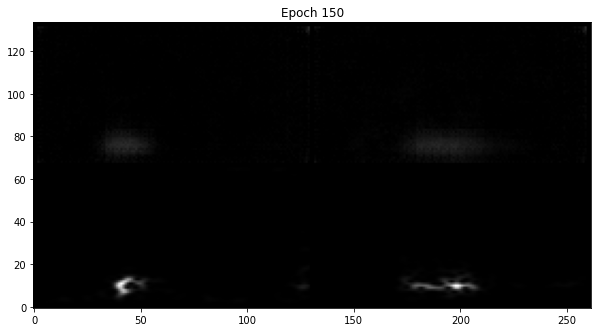

Trainer Results - Epoch 151 - Avg mse: 0.00
Training Results - Epoch 151 - Avg mse: 9.35
Validation Results - Epoch 151 - Avg mse: 9.46
Trainer Results - Epoch 152 - Avg mse: 0.00
Training Results - Epoch 152 - Avg mse: 9.33
Validation Results - Epoch 152 - Avg mse: 9.44
Trainer Results - Epoch 153 - Avg mse: 0.00
Training Results - Epoch 153 - Avg mse: 9.31
Validation Results - Epoch 153 - Avg mse: 9.41
Trainer Results - Epoch 154 - Avg mse: 0.00
Training Results - Epoch 154 - Avg mse: 9.28
Validation Results - Epoch 154 - Avg mse: 9.39
Trainer Results - Epoch 155 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 155 - Avg mse: 9.26
Validation Results - Epoch 155 - Avg mse: 9.37


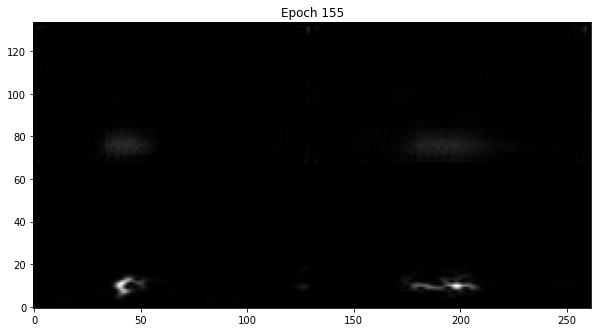

Trainer Results - Epoch 156 - Avg mse: 0.00
Training Results - Epoch 156 - Avg mse: 9.24
Validation Results - Epoch 156 - Avg mse: 9.34
Trainer Results - Epoch 157 - Avg mse: 0.00
Training Results - Epoch 157 - Avg mse: 9.21
Validation Results - Epoch 157 - Avg mse: 9.32
Trainer Results - Epoch 158 - Avg mse: 0.00
Training Results - Epoch 158 - Avg mse: 9.19
Validation Results - Epoch 158 - Avg mse: 9.30
Trainer Results - Epoch 159 - Avg mse: 0.00
Training Results - Epoch 159 - Avg mse: 9.17
Validation Results - Epoch 159 - Avg mse: 9.28
Trainer Results - Epoch 160 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 160 - Avg mse: 9.15
Validation Results - Epoch 160 - Avg mse: 9.26


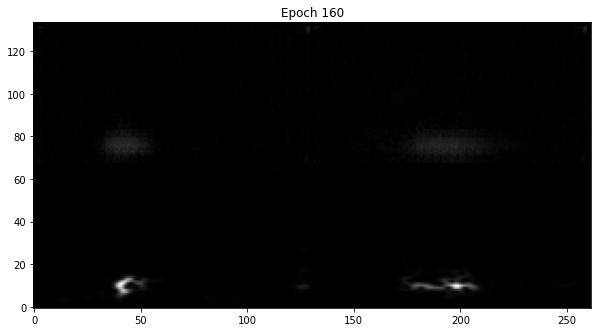

Trainer Results - Epoch 161 - Avg mse: 0.00
Training Results - Epoch 161 - Avg mse: 9.13
Validation Results - Epoch 161 - Avg mse: 9.24
Trainer Results - Epoch 162 - Avg mse: 0.00
Training Results - Epoch 162 - Avg mse: 9.11
Validation Results - Epoch 162 - Avg mse: 9.22
Trainer Results - Epoch 163 - Avg mse: 0.00
Training Results - Epoch 163 - Avg mse: 9.09
Validation Results - Epoch 163 - Avg mse: 9.20
Trainer Results - Epoch 164 - Avg mse: 0.00
Training Results - Epoch 164 - Avg mse: 9.07
Validation Results - Epoch 164 - Avg mse: 9.18
Trainer Results - Epoch 165 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 165 - Avg mse: 9.05
Validation Results - Epoch 165 - Avg mse: 9.16


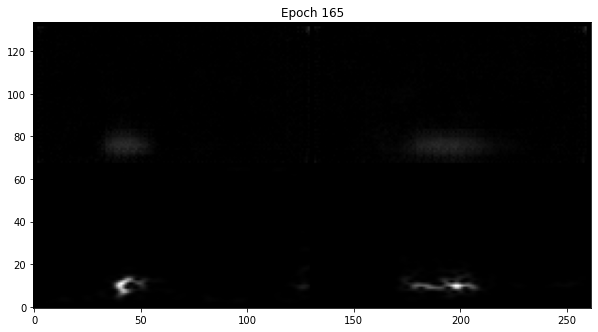

Trainer Results - Epoch 166 - Avg mse: 0.00
Training Results - Epoch 166 - Avg mse: 9.03
Validation Results - Epoch 166 - Avg mse: 9.14
Trainer Results - Epoch 167 - Avg mse: 0.00
Training Results - Epoch 167 - Avg mse: 9.01
Validation Results - Epoch 167 - Avg mse: 9.12
Trainer Results - Epoch 168 - Avg mse: 0.00
Training Results - Epoch 168 - Avg mse: 8.99
Validation Results - Epoch 168 - Avg mse: 9.10
Trainer Results - Epoch 169 - Avg mse: 0.00
Training Results - Epoch 169 - Avg mse: 8.97
Validation Results - Epoch 169 - Avg mse: 9.08
Trainer Results - Epoch 170 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 170 - Avg mse: 8.95
Validation Results - Epoch 170 - Avg mse: 9.07


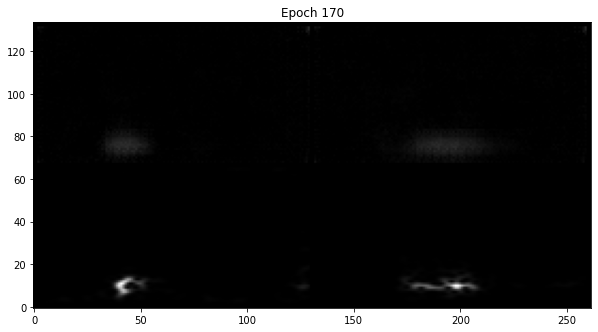

Trainer Results - Epoch 171 - Avg mse: 0.00
Training Results - Epoch 171 - Avg mse: 8.93
Validation Results - Epoch 171 - Avg mse: 9.05
Trainer Results - Epoch 172 - Avg mse: 0.00
Training Results - Epoch 172 - Avg mse: 8.92
Validation Results - Epoch 172 - Avg mse: 9.03
Trainer Results - Epoch 173 - Avg mse: 0.00
Training Results - Epoch 173 - Avg mse: 8.90
Validation Results - Epoch 173 - Avg mse: 9.02
Trainer Results - Epoch 174 - Avg mse: 0.00
Training Results - Epoch 174 - Avg mse: 8.88
Validation Results - Epoch 174 - Avg mse: 9.00
Trainer Results - Epoch 175 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 175 - Avg mse: 8.87
Validation Results - Epoch 175 - Avg mse: 8.98


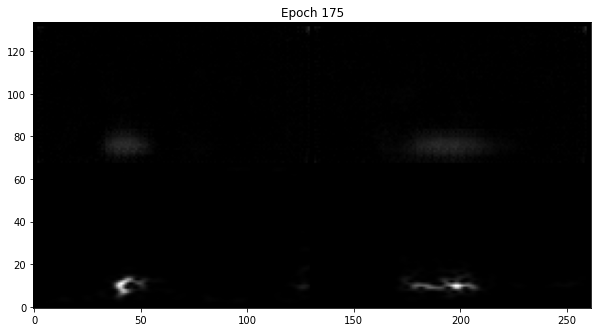

Trainer Results - Epoch 176 - Avg mse: 0.00
Training Results - Epoch 176 - Avg mse: 8.85
Validation Results - Epoch 176 - Avg mse: 8.97
Trainer Results - Epoch 177 - Avg mse: 0.00
Training Results - Epoch 177 - Avg mse: 8.83
Validation Results - Epoch 177 - Avg mse: 8.95
Trainer Results - Epoch 178 - Avg mse: 0.00
Training Results - Epoch 178 - Avg mse: 8.82
Validation Results - Epoch 178 - Avg mse: 8.94
Trainer Results - Epoch 179 - Avg mse: 0.00
Training Results - Epoch 179 - Avg mse: 8.80
Validation Results - Epoch 179 - Avg mse: 8.92
Trainer Results - Epoch 180 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 180 - Avg mse: 8.78
Validation Results - Epoch 180 - Avg mse: 8.91


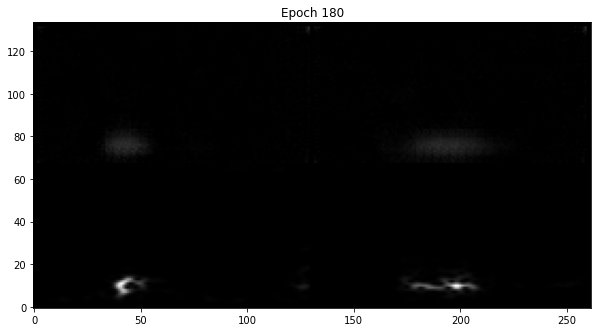

Trainer Results - Epoch 181 - Avg mse: 0.00
Training Results - Epoch 181 - Avg mse: 8.77
Validation Results - Epoch 181 - Avg mse: 8.89
Trainer Results - Epoch 182 - Avg mse: 0.00
Training Results - Epoch 182 - Avg mse: 8.75
Validation Results - Epoch 182 - Avg mse: 8.88
Trainer Results - Epoch 183 - Avg mse: 0.00
Training Results - Epoch 183 - Avg mse: 8.74
Validation Results - Epoch 183 - Avg mse: 8.86
Trainer Results - Epoch 184 - Avg mse: 0.00
Training Results - Epoch 184 - Avg mse: 8.72
Validation Results - Epoch 184 - Avg mse: 8.85
Trainer Results - Epoch 185 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 185 - Avg mse: 8.71
Validation Results - Epoch 185 - Avg mse: 8.83


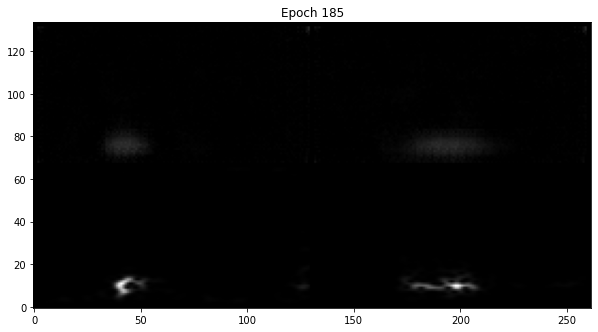

Trainer Results - Epoch 186 - Avg mse: 0.00
Training Results - Epoch 186 - Avg mse: 8.69
Validation Results - Epoch 186 - Avg mse: 8.82
Trainer Results - Epoch 187 - Avg mse: 0.00
Training Results - Epoch 187 - Avg mse: 8.67
Validation Results - Epoch 187 - Avg mse: 8.80
Trainer Results - Epoch 188 - Avg mse: 0.00
Training Results - Epoch 188 - Avg mse: 8.66
Validation Results - Epoch 188 - Avg mse: 8.79
Trainer Results - Epoch 189 - Avg mse: 0.00
Training Results - Epoch 189 - Avg mse: 8.64
Validation Results - Epoch 189 - Avg mse: 8.78
Trainer Results - Epoch 190 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 190 - Avg mse: 8.63
Validation Results - Epoch 190 - Avg mse: 8.76


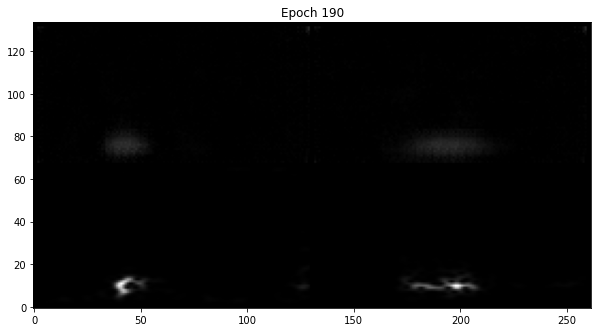

Trainer Results - Epoch 191 - Avg mse: 0.00
Training Results - Epoch 191 - Avg mse: 8.61
Validation Results - Epoch 191 - Avg mse: 8.75
Trainer Results - Epoch 192 - Avg mse: 0.00
Training Results - Epoch 192 - Avg mse: 8.60
Validation Results - Epoch 192 - Avg mse: 8.73
Trainer Results - Epoch 193 - Avg mse: 0.00
Training Results - Epoch 193 - Avg mse: 8.58
Validation Results - Epoch 193 - Avg mse: 8.72
Trainer Results - Epoch 194 - Avg mse: 0.00
Training Results - Epoch 194 - Avg mse: 8.57
Validation Results - Epoch 194 - Avg mse: 8.70
Trainer Results - Epoch 195 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 195 - Avg mse: 8.55
Validation Results - Epoch 195 - Avg mse: 8.69


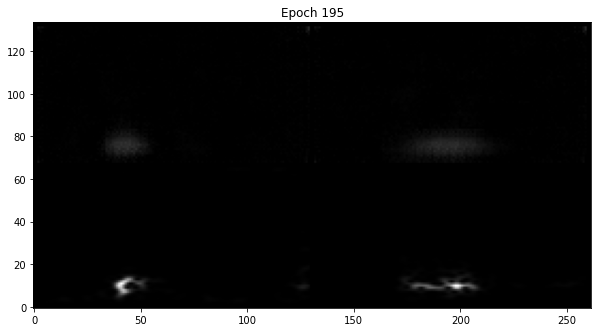

Trainer Results - Epoch 196 - Avg mse: 0.00
Training Results - Epoch 196 - Avg mse: 8.53
Validation Results - Epoch 196 - Avg mse: 8.67
Trainer Results - Epoch 197 - Avg mse: 0.00
Training Results - Epoch 197 - Avg mse: 8.52
Validation Results - Epoch 197 - Avg mse: 8.66
Trainer Results - Epoch 198 - Avg mse: 0.00
Training Results - Epoch 198 - Avg mse: 8.50
Validation Results - Epoch 198 - Avg mse: 8.64
Trainer Results - Epoch 199 - Avg mse: 0.00
Training Results - Epoch 199 - Avg mse: 8.49
Validation Results - Epoch 199 - Avg mse: 8.63
Trainer Results - Epoch 200 - Avg mse: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Results - Epoch 200 - Avg mse: 8.47
Validation Results - Epoch 200 - Avg mse: 8.62


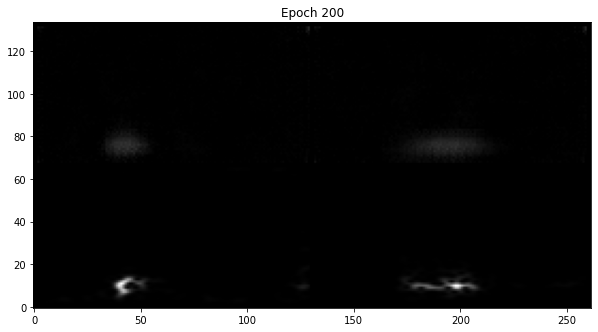

In [13]:
e = trainer.run(train_loader, max_epochs=200)

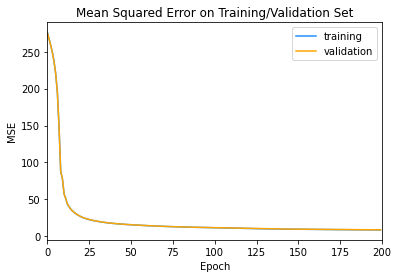

In [27]:
plt.plot(range(200), training_history['mse'], 'dodgerblue', label='training')
plt.plot(range(200), validation_history['mse'], 'orange', label='validation')
plt.xlim(0, 200)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error on Training/Validation Set')
plt.legend()

In [14]:
import importlib
importlib.reload(cluster)

<module 'RISCluster.processing.cluster' from '../../RISClusterPT/RISCluster/processing/cluster.py'>